#Ejemplo de una Red Generativa Adversativa (GAN) desde cero



## Verificación de GPU

In [1]:
import torch
print('GPU disponible:', torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = "cpu"
print('Usando dispositivo:', device)

GPU disponible: False
Usando dispositivo: cpu


## Implementando el generador y el discriminador

In [2]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Definimos una función para el generador
def make_generator_network(
    input_size=20,
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=784):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_g{i}',
                     nn.Linear(input_size, num_hidden_units))
    model.add_module(f'relu_g{i}', nn.LeakyReLU())
    input_size = num_hidden_units
  model.add_module(f'fc_g{num_hidden_layers}',
                   nn.Linear(input_size, num_output_units))
  model.add_module(f'tanh_g', nn.Tanh())
  return model

## Definimos una función para el discriminador
def make_discriminator_network(
    input_size,
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=1):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units, bias=False))
    model.add_module(f'relu_d{i}',nn.LeakyReLU())
    model.add_module('dropout', nn.Dropout(p=0.5))
    input_size = num_hidden_units
  model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
  model.add_module('sigmoid', nn.Sigmoid())
  return model

## Especificando las configuraciones del modelo

Puesto que estamos implementando una GAN sencilla haremos que el ventor de entrada tenga un tamaño de 20, las redes tendrán una sola capa oculta con 100 unidades. El tamaño de las imágenes MNIST es de 28×28

In [3]:
image_size = (28,28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
torch.manual_seed(1)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

print(gen_model)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size,)

print(disc_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)
Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Definiendo el conjunto de entrenamiento

In [4]:
import torchvision
from torchvision import transforms

image_path = './'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5,)),
])
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=True,
    transform=transform,
    download=True,
)

example, label = next(iter(mnist_dataset))



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 351kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 774kB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



A continuación crearemos un vector aleatorio $z$, basado en la distribución aleatoria deseada.

In [5]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size)*2 -1
  elif mode_z == 'normal':
    input_ze = torch.randn(batch_size, z_size)
  return input_z

## Ejemplo de los cálculos con una muestra

Tomaremos una muestra inicial para realizar algunos cálculos de ejemplo. Primero crearemos un lote de vectores $z$ con el que alimentaremos al generador para pasar sus resultados al discriminador para conseguir las probabilidades.

In [6]:
from torch.utils.data import DataLoader

batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)
torch.manual_seed(1)
mode_z = 'uniform'
input_z = create_noise(batch_size, z_size, mode_z)
print('input_z -- dimensiones:', input_z.shape)
print('input-real -- dimensiones:', input_real.shape)

g_output = gen_model(input_z)
print('Dimensiones de la salida del generador:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Probabilidad real del discriminador:', d_proba_real.shape)
print('Probabilidad fake del discriminador:', d_proba_fake.shape)

input_z -- dimensiones: torch.Size([32, 20])
input-real -- dimensiones: torch.Size([32, 784])
Dimensiones de la salida del generador: torch.Size([32, 784])
Probabilidad real del discriminador: torch.Size([32, 1])
Probabilidad fake del discriminador: torch.Size([32, 1])


## Entrenando el modelo

In [7]:
loss_fn = nn.BCELoss()
## Función de error para el generador
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Error del generador: {g_loss:.4f}')

## Función de error para el discriminador
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Error del discriminador:  Real  {d_loss_real:.4f}, Falso {d_loss_fake:.4f}')

Error del generador: 0.6983
Error del discriminador:  Real  0.7479, Falso 0.6885


In [8]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)).to(device)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size).to(device)

loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

Debido a que calcularemos el gradiente con respecto a los pesos del modelo y optimizar los parámetros del generador y discriminador por separado definiremos unas funciones auxiliares.

In [9]:
# Entrenamiento del discriminador

def d_train(x):
  disc_model.zero_grad()
  # Entrenamiento del discriminador con un lote real
  batch_size = x.size(0)
  x = x.view(batch_size, -1).to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device).to(device)
  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)
  # Entrenamiento del discriminador con un lote falso
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size, 1, device=device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
  # Actualización de los parámetros del discriminador usando retropropagación
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()
  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

# Entrenamiento del generador

def g_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_labels_real = torch.ones(batch_size, 1, device=device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  g_loss = loss_fn(d_proba_fake, g_labels_real)
  # Actualización de los parámetros del generador usando retropropagación
  g_loss.backward()
  g_optimizer.step()
  return g_loss.data.item()

In [10]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
def create_samples(g_model, input_z):
  g_output = g_model(input_z)
  images = torch.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2.0

epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100

for epoch in range(1, num_epochs+1):
  d_losses, g_losses = [], []
  d_vals_real, d_vals_fake = [], []
  for i, (x, _) in enumerate(mnist_dl):
    d_loss, d_proba_real, d_proba_fake = d_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_train(x))
    d_vals_real.append(d_proba_real.mean().cpu())
    d_vals_fake.append(d_proba_fake.mean().cpu())

  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())
  print(f'Epoca {epoch:03d} | Promedio de error >>'
        f'G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
        f' [D-real: {all_d_real[-1]:.4f}'
        f'D-falso: {all_d_fake[-1]:.4f}]')
  epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())


Epoca 001 | Promedio de error >>G/D 0.8728/0.9571 [D-real: 0.7781D-falso: 0.4792]
Epoca 002 | Promedio de error >>G/D 0.8619/1.2325 [D-real: 0.5722D-falso: 0.4573]
Epoca 003 | Promedio de error >>G/D 0.9368/1.2084 [D-real: 0.5726D-falso: 0.4264]
Epoca 004 | Promedio de error >>G/D 0.8948/1.2394 [D-real: 0.5617D-falso: 0.4379]
Epoca 005 | Promedio de error >>G/D 0.9059/1.2534 [D-real: 0.5592D-falso: 0.4420]
Epoca 006 | Promedio de error >>G/D 0.8865/1.2481 [D-real: 0.5602D-falso: 0.4409]
Epoca 007 | Promedio de error >>G/D 1.0411/1.1454 [D-real: 0.6007D-falso: 0.3963]
Epoca 008 | Promedio de error >>G/D 1.0545/1.1593 [D-real: 0.5999D-falso: 0.4018]
Epoca 009 | Promedio de error >>G/D 1.0130/1.1690 [D-real: 0.5957D-falso: 0.4063]
Epoca 010 | Promedio de error >>G/D 0.9985/1.1763 [D-real: 0.5940D-falso: 0.4093]
Epoca 011 | Promedio de error >>G/D 0.9956/1.1766 [D-real: 0.5978D-falso: 0.4077]
Epoca 012 | Promedio de error >>G/D 0.9774/1.1877 [D-real: 0.5887D-falso: 0.4128]
Epoca 013 | Prom

## Gráficos del generador y el discriminante

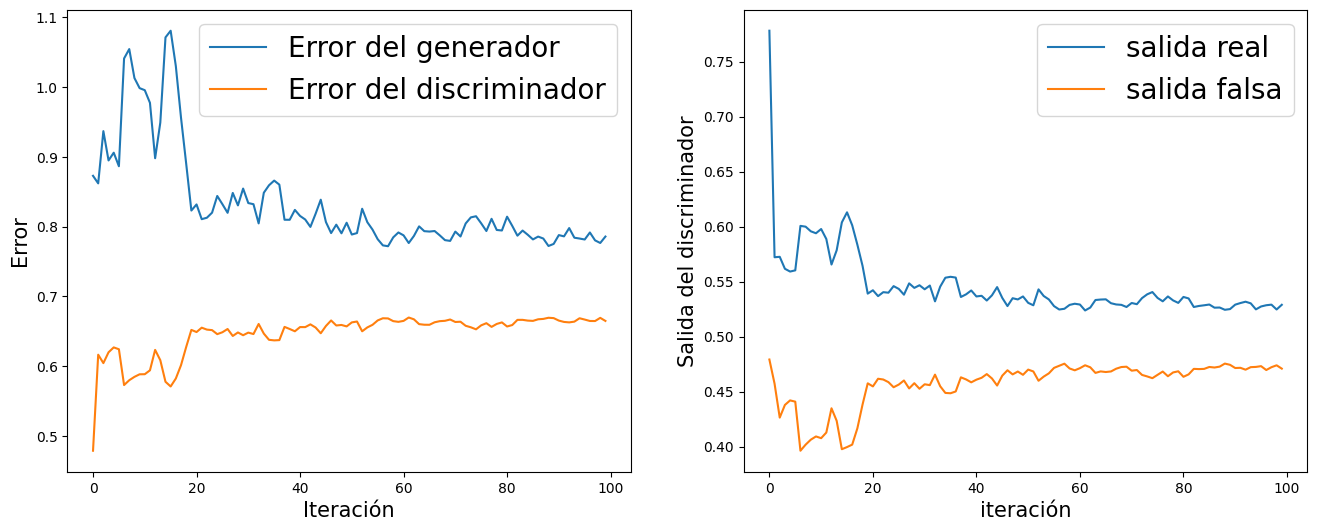

In [11]:
import itertools
fig = plt.figure(figsize=(16,6))

## Graficando el error
ax = fig.add_subplot(1,2,1)
plt.plot(all_g_losses, label='Error del generador')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Error del discriminador')
plt.legend(fontsize=20)
ax.set_xlabel('Iteración', fontsize=15)
plt.ylabel('Error', size=15)

# Graficando las salidas del discriminador
ax = fig.add_subplot(1,2,2)
plt.plot(all_d_real, label='salida real')
plt.plot(all_d_fake, label='salida falsa')
plt.legend(fontsize=20)
ax.set_xlabel('iteración', size=15)
ax.set_ylabel('Predicción del discriminador', size=15)
plt.show()

## Visualizando las imágenes generadas

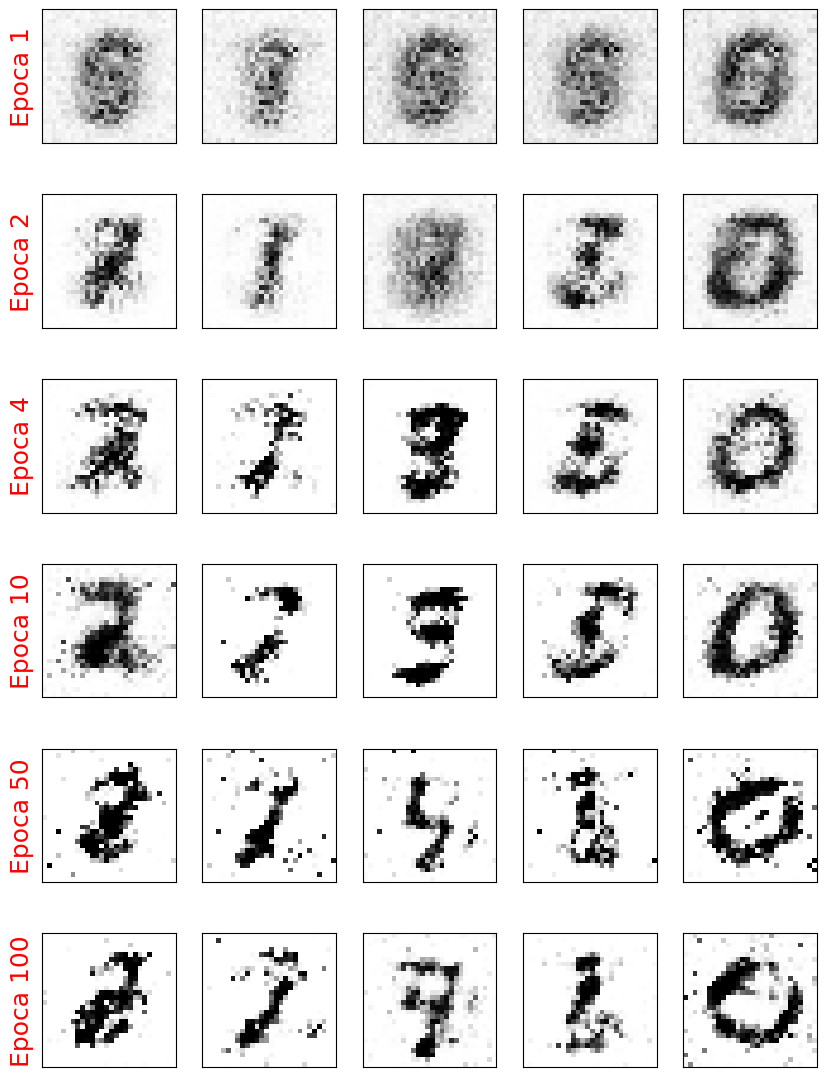

In [12]:
selected_epochs = [1,2,4,10,50,100]
fig = plt.figure(figsize=(10,14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06, 0.5, f'Epoca {e}',
          rotation=90, size=18, color='red',
          horizontalalignment='right',
          verticalalignment='center',
          transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')
plt.show()